# Unsupervised Image Retrieval

This toy project is about using unsupervised deep learning model  (Autoencoder)  
with K-nearest neighbors or Locality Sensistive Hashing to find the most similar images

In [ ]:
# import general libraries
import numpy as np
import pickle
import os
from tqdm import tqdm
from multiprocess import Pool
import random

# import libraries for plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# import image processing libraries
import cv2

# import sklearn libraries
from sklearn.model_selection import train_test_split

# import tensorflow and keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Add, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import fashion_mnist

# google colab for save model
from google.colab import drive

# KNN
from sklearn.neighbors import NearestNeighbors


In [ ]:
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
# define some constants
MODEL_LOC='/content/MyDrive/MyDrive/Colab Notebooks/Unsupervised Image Search/models/model.h5'
MODEL_LOC2='/content/MyDrive/MyDrive/Colab Notebooks/Unsupervised Image Search/models/model_0005.h5'

## 2 Prepare Data 


1.   download the dataset
2.   check its shape
3.   normalize the data
4.   add  channel 
5.   visualize sample images

In [ ]:
# We are not going to use Y for this project
(X_train, _), (X_test, _) = fashion_mnist.load_data()
print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)

Training set size: (60000, 28, 28)
Test set size: (10000, 28, 28)


In [ ]:
# normalize the data
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized= X_test.astype('float32') / 255.0

In [ ]:
# add channel 
X_train = np.expand_dims(X_train, axis=-1)
X_train_normalized = np.expand_dims(X_train_normalized, axis=-1)

X_test = np.expand_dims(X_test, axis=-1)
X_test_normalized = np.expand_dims(X_test_normalized, axis=-1)

print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)
print('Training set size  (normalized):', X_train_normalized.shape)
print('Test set size (normalized)', X_test_normalized.shape)

Training set size: (60000, 28, 28, 1)
Test set size: (10000, 28, 28, 1)
Training set size  (normalized): (60000, 28, 28, 1)
Test set size (normalized) (10000, 28, 28, 1)


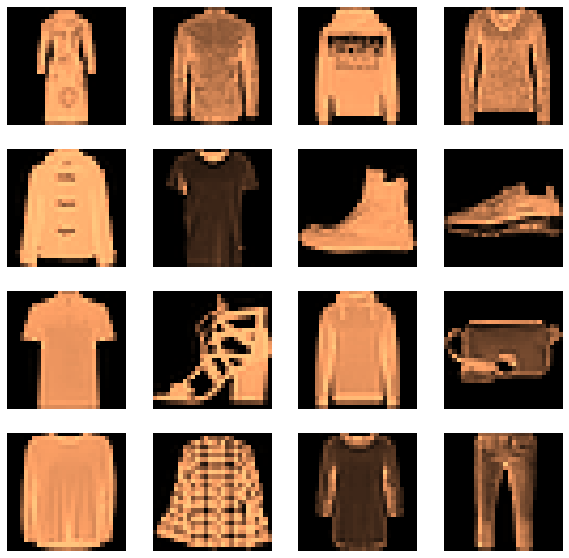

In [ ]:
# visualize the data
n_rows = n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

axes =  axes.ravel()
for i in range(n_rows * n_cols):
  rnd = np.random.randint(len(X_train))
  axe = axes[i]
  axe.imshow(X_train[rnd].squeeze(),  cmap=plt.cm.copper)
  axe.axis('off')

## 2 Build the Model

In [ ]:
# input
input_img = Input(shape=(28, 28, 1))

# encoder
x1 = Conv2D(16, (3, 3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01))(input_img)
x2 = Conv2D(16, (3, 3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01))(x1)
x3 = MaxPool2D(pool_size=(2,2), padding='same')(x2)

x4 = Conv2D(8, (3, 3), activation='elu', padding='same', kernel_regularizer=regularizers.l1(10e-10) )(x3)
x5 = Conv2D(8, (3, 3), activation='elu', padding='same', kernel_regularizer=regularizers.l1(10e-10) )(x4)
x6 = MaxPool2D( pool_size=(2,2), padding='same')(x5)

encoded = Conv2D(8, (3, 3), activation='elu', padding='same', kernel_regularizer=regularizers.l1(10e-10), name='encoder')(x6)
#encoded = MaxPool2D( pool_size=(2,2), padding='same', name='encoder')(encoded_conv)

# decoder
#decoder_conv = Conv2D(8, (3, 3), activation='elu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(encoded)
x7 = UpSampling2D()(encoded)
x8 = Conv2D(8, (3, 3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01))(x7)
x9 = Conv2D(8, (3, 3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(16, (3, 3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01))(x11)
x13 = Conv2D(16, (3, 3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01))(x12)
x14 = Add()([x2, x13])

decoded =  Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_regularizer=regularizers.l2(0.01), name='decoder')(x14)

autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 16)   2320        conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_9[0][0]                   
____________________________________________________________________________________________

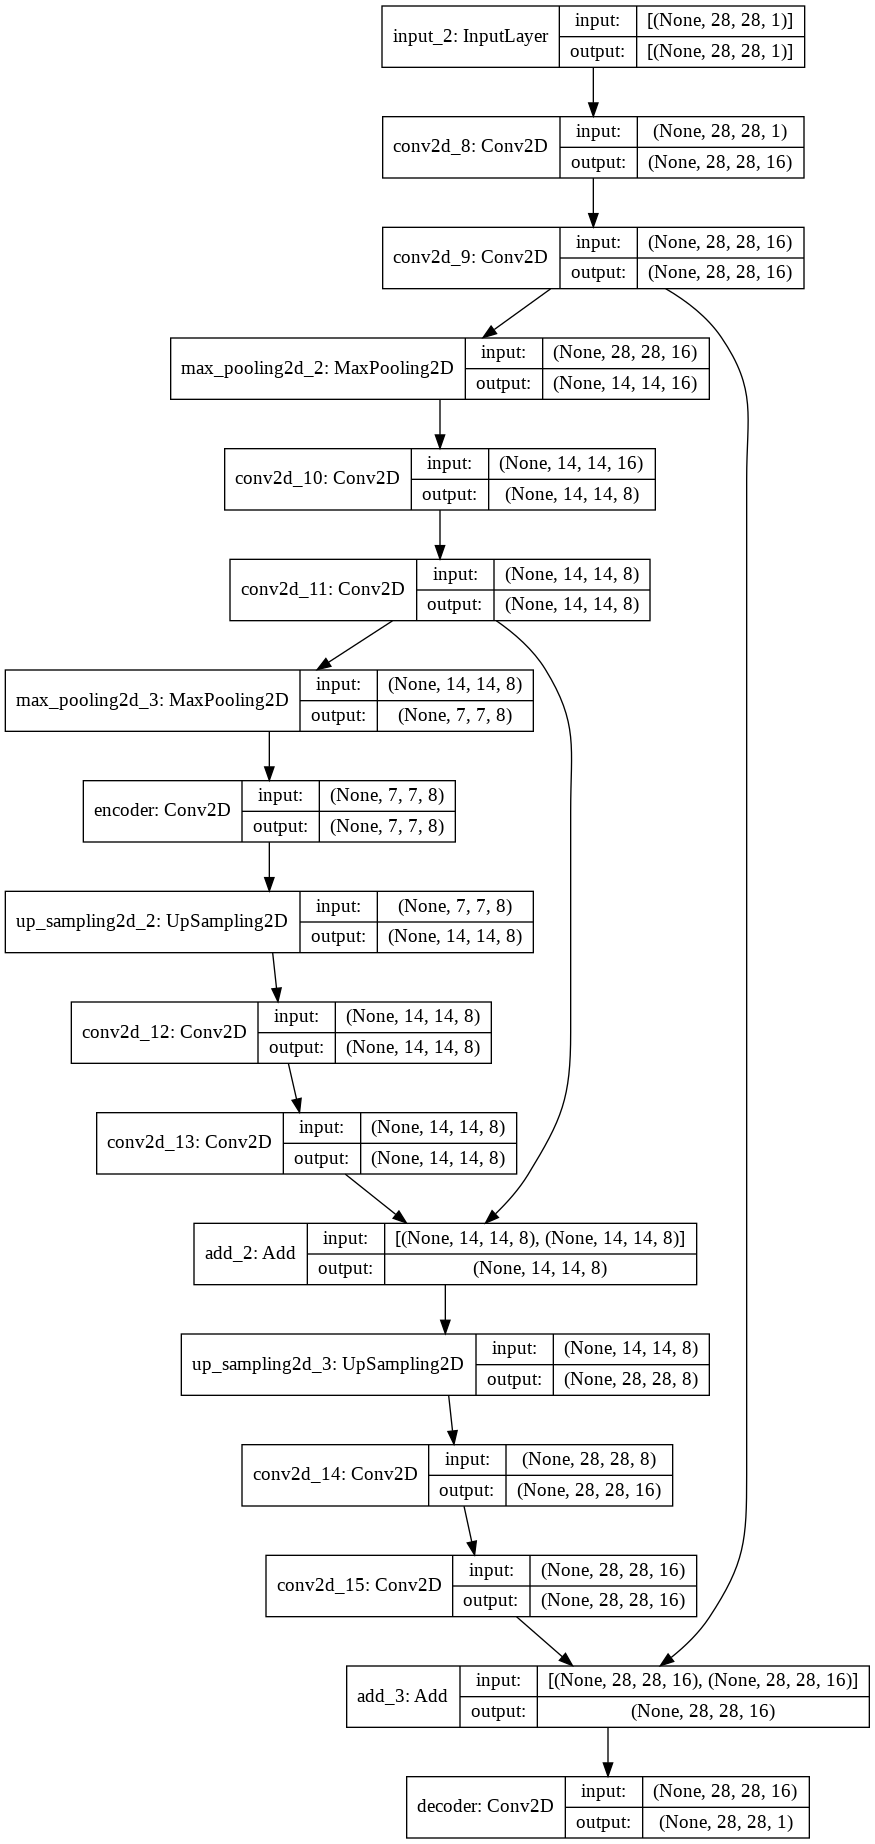

In [ ]:
keras.utils.plot_model( autoencoder, show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-07)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint(MODEL_LOC, save_best_only = True)

In [ ]:
def scheduler(epoch):
    lr = 0.
    if epoch < 20 : 
        lr = 0.001
    else:
        #lr = 0.001 * np.exp(0.1 * (10 - epoch))
        lr =  0.001 * np.exp(0.0070 * (10 - (epoch -20)))
    print("current running rate:", lr )
    return lr

lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = autoencoder.fit(X_train_normalized,X_train_normalized,
            batch_size=128,
            epochs=200,
            validation_data=(X_test_normalized, X_test_normalized),
            callbacks=[early_stopper, model_checkpoint, lrscheduler])

Epoch 1/200
current running rate: 0.001
469/469 [==============================] - 12s 23ms/step - loss: 0.2517 - accuracy: 0.4966 - val_loss: 0.0248 - val_accuracy: 0.5063
Epoch 2/200
current running rate: 0.001
469/469 [==============================] - 10s 22ms/step - loss: 0.0236 - accuracy: 0.5095 - val_loss: 0.0211 - val_accuracy: 0.5067
Epoch 3/200
current running rate: 0.001
469/469 [==============================] - 10s 22ms/step - loss: 0.0204 - accuracy: 0.5095 - val_loss: 0.0192 - val_accuracy: 0.5069
Epoch 4/200
current running rate: 0.001
469/469 [==============================] - 10s 22ms/step - loss: 0.0189 - accuracy: 0.5100 - val_loss: 0.0181 - val_accuracy: 0.5069
Epoch 5/200
current running rate: 0.001
469/469 [==============================] - 10s 22ms/step - loss: 0.0179 - accuracy: 0.5089 - val_loss: 0.0173 - val_accuracy: 0.5069
Epoch 6/200
current running rate: 0.001
469/469 [==============================] - 10s 22ms/step - loss: 0.0172 - accuracy: 0.5093 - va

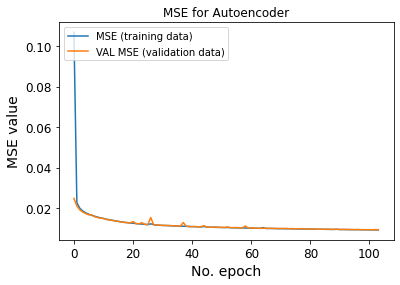

In [ ]:
# Plot history: MSE
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='VAL MSE (validation data)')
plt.title('MSE for Autoencoder')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

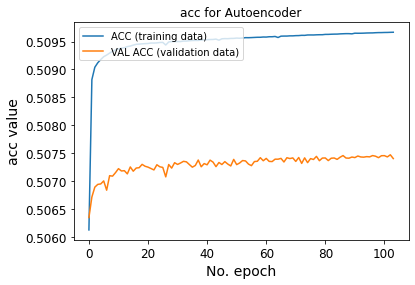

In [ ]:
# Plot history: ACC
plt.plot(history.history['accuracy'], label='ACC (training data)')
plt.plot(history.history['val_accuracy'], label='VAL ACC (validation data)')
plt.title('acc for Autoencoder')
plt.ylabel('acc value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

There's a big gap between train accuracy and validation accuracy.
We could add more regularization by adding more weight on L2 normalization or add droupout

##3 Get the encoder

In [ ]:
autoencoder.save('/content/MyDrive/MyDrive/Colab Notebooks/Unsupervised Image Search/models/autoencoder.h5')

In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
encoder.save('/content/MyDrive/MyDrive/Colab Notebooks/Unsupervised Image Search/models/encoder.h5')

##4 Image Search using KNN

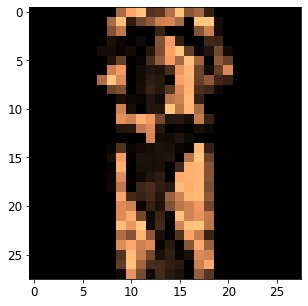

In [65]:
# display the image
query = X_test_normalized[887]
plt.figure(figsize = (5,5))
plt.imshow(query.reshape(28, 28), cmap=plt.cm.copper)

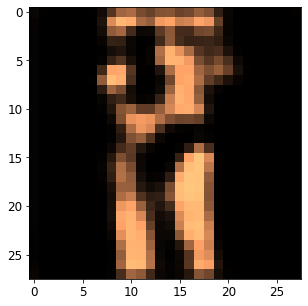

In [66]:
#verify the autoencoder result
decoded_query_img = autoencoder.predict(query.reshape(1,28,28,1))
plt.figure(figsize = (5,5))
plt.imshow(decoded_query_img.reshape(28, 28), cmap=plt.cm.copper)

In [67]:
# remove query image from search
print('initial shape:', X_test_normalized.shape)
X_test_target = np.delete(X_test_normalized, 887, axis=0)
print('current shape:', X_test_target.shape)


initial shape: (10000, 28, 28, 1)
current shape: (9999, 28, 28, 1)


In [68]:
# encoder the target images
codes = encoder.predict(X_test_target)
query_code = encoder.predict(query.reshape(1,28,28,1))

print('codes.shape:', codes.shape)
print('query_code.shape:', query_code.shape)

codes.shape: (9999, 7, 7, 8)
query_code.shape: (1, 7, 7, 8)


In [69]:
n_neighbors = 5
codes = codes.reshape(-1, 7*7*8)
query_code = query_code.reshape(1, 7*7*8)


In [70]:
# fit KNN
nearestNeighbors= NearestNeighbors(n_neighbors=n_neighbors).fit(codes)


In [71]:
distances, indices = nearestNeighbors.kneighbors(np.array(query_code))
closest_images = X_test_target[indices]
closest_images = closest_images.reshape(-1,28,28,1)

display the result

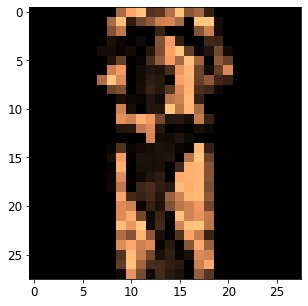

In [74]:
query = X_test_normalized[887]
plt.figure(figsize = (5,5))
plt.imshow(query.reshape(28, 28), cmap=plt.cm.copper)

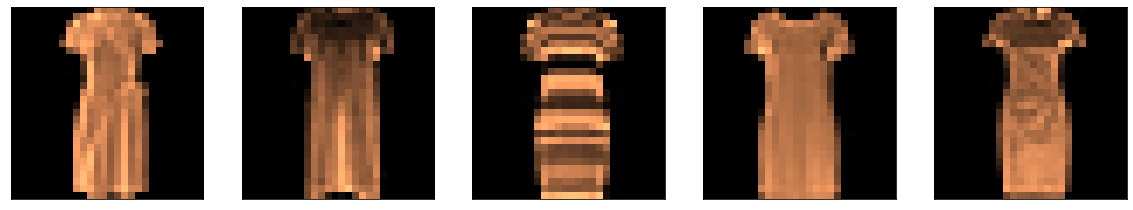

In [75]:
plt.figure(figsize=(20, 6))
for i in range(n_neighbors):
    # display original
    ax = plt.subplot(1, n_neighbors, i+1)
    plt.imshow(closest_images[i].reshape(28, 28), cmap=plt.cm.copper)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
